## Boundary element method for acoustics (3D)


In this section, the same internal and external problem will be solved using the BEM and constant elements: triangular and quadrilateral elements. The problem which will be solved is the vibrating cylinder.

The vibrating cylinder is a classical wave propagation problem in 2D and 3D space in which an infinite cylinder is let to vibrate in a free-space domain. This problem closely resembles Green's point source perturbation of an infinite domain. 

The problem is stated as such: let an infinite acoustically rigid cylinder vibrate in an infinite acoustic domain, what is the velocity potential and acoustic pressure field in the vicinities of the cylinder, in a plane parallel to the radial direction? 

The walls of the cylinder are subjected to Neumann boundary conditions ($\frac{\partial \phi}{\partial n} = \bar{q}$). The analytical solution is

\begin{equation}\label{cyl_anal}
	\phi_{cyl} (r) = - \frac{V}{k} \frac{H_0 ^{(2)} (k r)}{H_1 ^{(2)} (k a)},
\end{equation}
where $V$ is the amplitude of the cylinder vibration (set to unity), $k$ is the wave number, $a$ is the radius of the cylinder, $r$ is the distance from the cylinder, $H_0 ^{(2)}$ and $H_1 ^{(2)}$ are the Hankel functions of second species and order 0 and 1, respectively. 

#### Internal problem - acoustic duct

In order to assess the validity of the programs, a simple internal acoustics problem will be solved using the triangular and quadrilateral elements: the acoustic duct problem. This problem consists of a cylindrical duct which can be either open on both ends, closed on one end and open on the other or closed in both ends. The analytical solution can be obtained by solving the time-harmonic wave equation by separation of variables and the resonance frequencies are given by
- closed duct on both ends
\begin{equation}
    F_{closed\ duct}\ (n,L) = \frac{\pi\ n\ c}{L}
\end{equation}
where $c$ is the wave propagation speed, $n=0,1,2,...$ is the mode number and $L$ is the length of the duct. The frequency is in rad/s, divide it to $2\ pi$ to obtain the frequency in Hz. The duct which will be studied has length = 100 mm and diameter = 10 mm. The speed of sound is $c = 343$ m/s and only the first non-zero mode will be studied ($n=1$).

The acoustic flux is zero at the walls of the duct. So a Neumann boundary condition is applied to the whole boundary, such that $\frac{\partial \phi}{\partial n} = \bar{q}$.

In [2]:
c = 343*1000 # Speed of propagation in mm/s
F_closed(n,L,c) = pi*n*c/L # Analytical resonance frequency in rad/s
for n=1:3
    println("Mode n = $(n), L = $(L=100) m, F = $(F_closed(n,L,c)/(2*pi)) Hz.")
end

Mode n = 1, L = 100 m, F = 1715.0 Hz.
Mode n = 2, L = 100 m, F = 3430.0 Hz.
Mode n = 3, L = 100 m, F = 5145.0 Hz.


Notice that the actual solution is simply a time and space harmonic in which the velocity potential (proportional to the acoustic pressure) assumes its maximum value at the walls of the duct. 

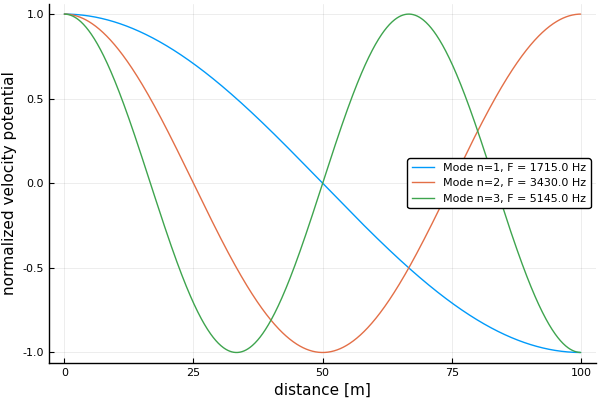

In [9]:
using Plots
pyplot()
L=100
phi_closed(x,n,L,c) = cos.(n*pi*(x./L))
x1 = 0.01:0.1:L
n=1
plot(x1,phi_closed(x1,n,L,c),xlabel="distance [m]",ylabel="normalized velocity potential",label="Mode n=$(n), F = $(F_closed(n,L,c)/(2*pi)) Hz")
n=2; plot!(x1,phi_closed(x1,n,L,c),xlabel="distance [m]",ylabel="normalized velocity potential",label="Mode n=$(n), F = $(F_closed(n,L,c)/(2*pi)) Hz")
n=3; plot!(x1,phi_closed(x1,n,L,c),xlabel="distance [m]",ylabel="normalized velocity potential",label="Mode n=$(n), F = $(F_closed(n,L,c)/(2*pi)) Hz")


The conventional boundary integral equation (CBIE) relates the velocity potential $\phi$ at point $x'$, known as source point, and its normal derivative at the boundary of the domain $\Gamma = \partial \Omega$  at every other point $x$ (field points). The CBIE for the BEM can be written as

\begin{equation}
 c(x') \phi(x') = \int_{\Gamma} \frac{\partial \phi (x)}{\partial n} \phi^{*}(x',x,k) d \Gamma - \int_{\Gamma} \phi(x) \frac{\partial \phi^{*}(x',x,k)}{\partial n} d \Gamma
\end{equation}
where the jump term is $c(x') = 1 / 2$ for smooth boundary on $x'$. A geometric approximation is applied to the boundary such that $\Gamma \approx \sum_{i=1}^{NE} \Gamma_i$. After the discretization, a linear system of equations is defined such that the terms of the CBIE:

\begin{equation}\label{eq_discr}
  \boldsymbol{H} \boldsymbol{\phi} = \boldsymbol{G} \boldsymbol{ \frac{\partial \phi}{\partial n}}.
\end{equation}

The left and right hand sides of this matricial equation contains vectors which are populated with information about the velocity potential and its normal derivative. This matricial system can be rearranged such that all of the unknowns of this vectors are on the left side and all of the knowns are on the right side hand of the equation. This process is known as applying the boundary conditions. The result is a linear system which can be solved directly.

\begin{equation}
  \boldsymbol{A} \boldsymbol{x} = \boldsymbol{b}.
\end{equation}


Once the system is solved and vector $x$ is known, one applies the boundary conditions again to build vector $\boldsymbol{\phi }$ and $\boldsymbol{\frac{\partial \phi }{\partial n} }$.

In [ ]:
include("../BEM_base.jl")

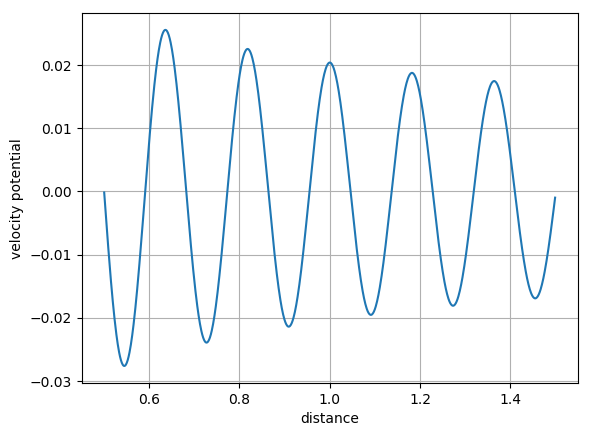

PyObject Text(24,0.5,'velocity potential')

In [22]:
#################### Test case 5 ####################
### Vibrating cylinder
# An acoustically rigid cylinder is let to vibrate in an
#infinite acoustic domain at frequency ω so that the wavenumber is k = ω/c.
### Analytical solution
#The analytical solution for the vibrating cylinder obtained
#by applying variable separation in cylindrical coordinates
#of the Helmholtz equation is
phi_cylinder(k,r,x) = (1/k).*(besselh.(0,2,k.*x)./besselh.(1,2,k.*r));
#at a distance x from the cylinder of radius r.
x = 0.501:0.001:1.499
plot(x,real(phi_cylinder(11*pi,0.5,x)),label="velocity potential")
grid(1)
xlabel("distance")
ylabel("velocity potential")

In [40]:
function cylinder3D(ne = 100,r=1,L=10,c=[0 0],k=1)
    t=0; tH=0; tiso=0; ϵ=0; ϵH=0; ϵiso=0; phi=0; q=0; phi_dom=0;  phiH=0; qH=0; phi_domH=0;  phiiso=0; qiso=0; domiso=0;
    #3D constant elements
    include("../tests/data/dad_const3D.jl") # NOS_GEO, ELEM, CCFace
    PONTOS_dom1 = [];
    passo = 0.05;
    [append!(PONTOS_dom1,[i*passo -10 j*passo] for i=1:10,j=1:10)];
    [append!(PONTOS_dom1,[i*passo -7 j*passo] for i=1:10,j=1:10)];
    PONTOS_dom = zeros(size(PONTOS_dom1,1),3);
    [PONTOS_dom[i,:] = PONTOS_dom1[i] for i = 1:size(PONTOS_dom1,1)];
    info = [NOS_GEO, ELEM]
    phi,q,phi_pint,dphidz = const3D_tri.solve(info,PONTOS_dom,CCFace,k)
    Hphi,Hq,Hphi_pint,Hdphidz = const3D_tri.H_solve(info,PONTOS_dom,BCFace,k)
    ϵ = sqrt.((phi_cylinder(k,r,x) - phi).^2./(phi_cylinder(k,r,x)).^2)
    ϵH = sqrt(((dphidz - Hdphidz).^2)./(dphidz).^2)
    #NURBS
    PNTS = [1 0 0 0
              2 r 0 0
              3 r L 0
              4 0 L 0]
    SEGS = [1 1 2 0
            2 2 3 0
            3 3 4 0
            4 4 1 0]
    MESH = [1 10
             2 10
             3 10
             4 10]    
    BCSeg = [1 1 1
             2 1 1
             3 1 1
             4 1 1]
    crv = nurbs2D.format_dad(PNTS,SEGS,MESH,BCSeg)
    #sup = Array{Surf}(1)
    #sup[1] = nurbs2D.nrbrevolve(crv,[0.5, 0.5, 0.5],[1,0,0])
    return ϵ
end

cylinder3D (generic function with 6 methods)

In [41]:
cylinder3D()

LoadError: [91mBoundsError: attempt to access 2-element Array{Array{Float64,2},1} at index [3][39m

In [6]:
;pwd

/home/cafe/Dropbox/Alvaro&Éder/dev/new_bem/notebooks


In [ ]:
### Analytical solution
#The analytical solution for the scattering cylinder is
besseljprime(nu,x) = -1/2*(SpecialFunctions.besselj(nu-1,x) - SpecialFunctions.besselj(nu+1,x))
besselyprime(nu,x) = -1/2*(SpecialFunctions.bessely(nu-1,x) - SpecialFunctions.bessely(nu+1,x))
besselhprime(nu,x) = besseljprime(nu,x) + complex(0,1)*besselyprime(nu,x)

function phi_cyl_scat(k,r,θ,a)
    phi = -(SpecialFunctions.besselj(1,k*a)/SpecialFunctions.besselh(1,k*a))*SpecialFunctions.besselh(0,k*r)
    for n in 1:1:100
        phi += (complex(0,1)^n)*(besseljprime(n,k*a)/besselhprime(n,k*a))*besselh(n,k*r)*cos(n*θ)
    end
    return phi
end
function cyl_scat3D(ne = 100,r=0.5,c=[0 0],k=1)
    t=0; tH=0; tiso=0; ϵ=0; ϵH=0; ϵiso=0; phi=0; q=0; phi_dom=0;  phiH=0; qH=0; phi_domH=0;  phiiso=0; qiso=0; domiso=0;
    return ϵH
end

In [ ]:
#################### Test case 7 ####################
### Pulsating sphere
# An acoustically rigid sphere is let to vibrate in an
#infinite acoustic domain at frequency ω so that the wavenumber is k = ω/c.
### Analytical solution
#The analytical solution for the scattering cylinder is
phi_sphere(k,r,a,ρ,c) = a/r*ρ*c*(-complex(0,1)*k*a/(1+complex(0,1)*k*a))*exp(complex(0,1)*k*(r-a));
#at a distance x from the cylinder of radius r.
### BEM model

#################### Test case 8 ####################
### Plane wave scattering on a rigid sphere
# An acoustically rigid sphere is let to vibrate in an
#infinite acoustic domain at frequency ω so that the wavenumber is k = ω/c.
# The sphere also scatters a plane wave with direction d = (dx,dy,dz) and
#wavenumber k_inc, amplitude a_inc. 
### Analytical solution
#The analytical solution for the scattering cylinder is
function phi_sph_scat(k,r,θ,a)
    phi = complex(0,0)
    for n in 1:10
        phi += ((complex(0,1)^(n) * (2*n +1) * SpecialFunctions.bessel(n,1,k*a))/SpecialFunctions.hankel(n,1,k*a))
    end
    return phi
end
#at a distance x from the cylinder of radius r.
### BEM model
